In [1]:
import torch
import numpy as np

import torch
import torch.nn as nn
import numpy as np
import sympy as sp
from tqdm import tqdm

# Import KAN module (assuming it's available)
from kan import *  # Ensure that 'kan' is installed or available in your PYTHONPATH

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def read_phi4pt_function(file_path):
    """
    Reads and preprocesses the 4pt function from a file.

    Args:
        file_path (str): Path to the 4pt function file.

    Returns:
        function: A numerical function of Z and Zb.
    """
    with open(file_path, 'r') as f:
        expr_str = f.read()
    expr_str = expr_str.replace('*^', 'e')
    expr_str = expr_str.replace('^', '**')
    expr_str = expr_str.replace('\n', ' ')
    Z_sym, Zb_sym = sp.symbols('Z Zb')
    expr = sp.sympify(expr_str, locals={'Z': Z_sym, 'Zb': Zb_sym})
    phi4pt_func = sp.lambdify((Z_sym, Zb_sym), expr, modules='numpy')
    return phi4pt_func

def crossing_equation0(Z, Zb, phi_func, Delta_phi):
        epsilon = 1e-6
        Z = Z.clip(min=epsilon, max=1 - epsilon)
        Zb = Zb.clip(min=epsilon, max=1 - epsilon)
        term1 = (Z * Zb) ** (-Delta_phi) * phi_func(Z, Zb)
        term2 = ((1 - Z) * (1 - Zb)) ** (-Delta_phi) * phi_func(1 - Z, 1 - Zb)
        return term1 - term2
 

    


def plot_results(model, phi4pt_func, device, grid_size=100,min=.15,max=.85):
    """
    Plots the original 4pt function, the KAN network's output, and their difference.

    Args:
        model: Trained KAN model.
        phi4pt_func (function): The original 4pt function.
        device (torch.device): Device to use.
        grid_size (int, optional): Grid size for plotting. Defaults to 100.
    """
    import matplotlib.pyplot as plt

    # Define the grid for plotting
    Z_plot = np.linspace(min,max, grid_size)
    Zb_plot = np.linspace(min,max, grid_size)
    Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
    Z_flat = Z_grid.flatten()
    Zb_flat = Zb_grid.flatten()

    # Convert grid points to tensors
    Z_tensor = torch.tensor(Z_flat, dtype=torch.float32, device=device)
    Zb_tensor = torch.tensor(Zb_flat, dtype=torch.float32, device=device)
    z=torch.stack((Z_tensor, Zb_tensor), dim=1)

    # Evaluate the original 4pt function on the grid
    phi4pt_values = phi4pt_func(z)
    phi4pt_grid = phi4pt_values.reshape(grid_size, grid_size).cpu().numpy()

    # Evaluate the KAN model output on the grid
    with torch.no_grad():
        
        
        outputs_plot = model(z).cpu().numpy().flatten()
    outputs_plot_grid = outputs_plot.reshape(grid_size, grid_size)

    # Compute the difference between the KAN output and the original 4pt function
    difference_grid = outputs_plot_grid - phi4pt_grid

    # Plot the original 4pt function
    plt.figure(figsize=(8, 6))
    plt.imshow(phi4pt_grid, extent=[min, max, min, max], origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Original 4pt Function Value')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Original 4pt Function φφφφ₄ₚₜ(Z, Zb)')
    plt.show()

    # Plot the KAN Neural Network Output
    plt.figure(figsize=(8, 6))
    plt.imshow(outputs_plot_grid, extent=[min, max,min, max], origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='KAN Neural Network Output')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('KAN Neural Network Output')
    plt.show()

    # Plot the Difference between KAN Output and Original 4pt Function
    plt.figure(figsize=(8, 6))
    plt.imshow(difference_grid, extent=[min, max,min, max], origin='lower', aspect='auto', cmap='seismic',
               vmin=-np.max(np.abs(difference_grid)), vmax=np.max(np.abs(difference_grid)))
    plt.colorbar(label='Difference (KAN Output - Original 4pt)')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Difference between KAN Output and Original 4pt Function')
    plt.show()


def plot_crossing_violation(phi_func_model, phi4pt_func, Delta_phi, device, grid_size=100,zmin=.05,zmax=.95):
    """
    Plots the crossing violation of both the KAN model and the original 4pt function.

    Args:
        model: Trained KAN model.
        phi4pt_func (function): The original 4pt function.
        Delta_phi (float): Scaling dimension.
        device (torch.device): Device to use.
        grid_size (int, optional): Grid size for plotting. Defaults to 100.
    """
    import matplotlib.pyplot as plt

    # Define the grid for plotting
    Z_plot = np.linspace(zmin, zmax, grid_size)
    Zb_plot = np.linspace(zmin,zmax, grid_size)
    Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
    Z_flat = Z_grid.flatten()
    Zb_flat = Zb_grid.flatten()

    # Clamping to avoid division by zero
    epsilon = 1e-8  # Small constant to prevent division by zero
    Z_clamped = np.clip(Z_flat, epsilon, 1 - epsilon)
    Zb_clamped = np.clip(Zb_flat, epsilon, 1 - epsilon)

    # Convert grid points to tensors
    Z_tensor = torch.tensor(Z_clamped, dtype=torch.float32, device=device)
    Zb_tensor = torch.tensor(Zb_clamped, dtype=torch.float32, device=device)

    # Define phi_func to use the KAN model for predictions
  
    z=torch.stack((Z_tensor, Zb_tensor), dim=1)
    # Compute the crossing equation values using the KAN model
    crossing_values_model = crossing_equation(z, phi_func_model, Delta_phi).detach()
    crossing_values_model_grid = crossing_values_model.reshape(grid_size, grid_size)

    # Plot the crossing violation of the KAN model
    plt.figure(figsize=(8, 6))
    max_abs_crossing = torch.max(torch.abs(crossing_values_model))
    plt.imshow(crossing_values_model_grid, extent=[zmin, zmax, zmin, zmax], origin='lower', aspect='auto', cmap='seismic',
               vmin=-max_abs_crossing, vmax=max_abs_crossing)
    plt.colorbar(label='Crossing Violation Value')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Crossing Violation of the KAN Model')
    plt.show()

    # Compute the crossing equation values using the original 4pt function
    crossing_values_phi4pt = crossing_equation(z, phi4pt_func, Delta_phi)
    crossing_values_phi4pt_grid = crossing_values_phi4pt.reshape(grid_size, grid_size)

    # Plot the crossing violation of the original 4pt function
    plt.figure(figsize=(8, 6))
    max_abs_crossing_phi4pt = torch.max(torch.abs(crossing_values_phi4pt))
    plt.imshow(crossing_values_phi4pt_grid, extent=[zmin, zmax, zmin,zmax], origin='lower', aspect='auto', cmap='seismic',
               vmin=-max_abs_crossing_phi4pt, vmax=max_abs_crossing_phi4pt)
    plt.colorbar(label='Crossing Violation Value')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Crossing Violation of the Original 4pt Function')
    plt.show()
def evaluate_model(model, phi4pt_func, device, num_points=1000):
    """
    Evaluates how well the KAN model represents the 4pt function on unseen data.

    Args:
        model: Trained KAN model.
        phi4pt_func (function): The original 4pt function.
        device (torch.device): Device to use.
        num_points (int, optional): Number of random points for evaluation. Defaults to 1000.

    Returns:
        float: Mean squared error between the KAN model predictions and the original 4pt function.
    """
    # Generate random points in [0, 1] x [0, 1]
    Z_vals = np.random.uniform(0.2, .8, num_points)
    Zb_vals = np.random.uniform(0.2, .8, num_points)
    points = np.vstack((Z_vals, Zb_vals)).T

    # Convert to torch tensors
    Z_tensor = torch.tensor(Z_vals, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_tensor = torch.tensor(Zb_vals, dtype=torch.float32, device=device).unsqueeze(1)

    # Evaluate the original 4pt function
    phi4pt_values = phi4pt_func(Z_vals, Zb_vals)
    phi4pt_tensor = torch.tensor(phi4pt_values, dtype=torch.float32, device=device).unsqueeze(1)

    # Evaluate the KAN model
    with torch.no_grad():
        inputs = torch.cat([Z_tensor, Zb_tensor], dim=1)
        outputs = model(inputs)

    # Compute the mean squared error
    mse = torch.mean((outputs - phi4pt_tensor) ** 2).item()

    print(f'Mean Squared Error on unseen data: {mse:.6e}')

    return mse

from sympy import symbols, sqrt
from sympy.printing.mathematica import mathematica_code

def print_symbolic(model):
    # Define the symbols in the expression
    x_1, x_2 = symbols('x_1 x_2')

    # Define the SymPy expression
    expr = model.symbolic_formula()[0][0]# Get all symbols in the expression
    symbols_in_expr = expr.free_symbols

    # Create a mapping from old symbols to new symbols (e.g., x_1 -> x1)
    subs_dict = {}
    for s in symbols_in_expr:
        old_name = s.name
        new_name = old_name.replace('_', '')
        new_symbol = symbols(new_name)
        subs_dict[s] = new_symbol

    # Substitute symbols in the expression with the new symbols
    expr_subs = expr.subs(subs_dict)

    # Generate the Mathematica code
    mathematica_expr = mathematica_code(expr_subs)

    print(mathematica_expr)        
    
    
def create_truncated_gaussian_dataset(f, 
                                      mean=[0.0, 0.0],
                                      sigma=1.0, 
                                      max_radius=1.0,
                                      n_var=2, 
                                      f_mode='col',
                                      train_num=1000, 
                                      test_num=1000,
                                      normalize_input=False,
                                      normalize_label=False,
                                      device='cpu',
                                      seed=0):
    '''
    Create a dataset from a 2D Gaussian distribution truncated at a given radius.
    The Gaussian is centered at 'mean' and has standard deviation 'sigma'.
    Points with (x - mean_x)^2 + (y - mean_y)^2 > max_radius^2 are rejected.

    Args:
    -----
        f : function
            The function used to create the labels from the input data.
        mean : list or tuple of length 2
            The mean of the Gaussian distribution, [mean_x, mean_y].
        sigma : float
            The standard deviation of the 2D Gaussian (mean given by 'mean').
        max_radius : float
            The maximum radius cutoff around the mean. Points outside this radius are rejected.
        n_var : int
            Number of variables (should be 2 for this approach).
        f_mode : str
            How to apply the function f: 'col' if f expects shape [N, n_var], 
            'row' if it expects shape [n_var, N].
        train_num : int
            The number of training samples.
        test_num : int
            The number of test samples.
        normalize_input : bool
            Whether to normalize the input.
        normalize_label : bool
            Whether to normalize the labels.
        device : str
            Device for returned tensors.
        seed : int
            Random seed.

    Returns:
    --------
        dataset : dict
            'train_input', 'train_label', 'test_input', 'test_label'
    '''

    if n_var != 2:
        raise ValueError("This method is defined for a 2D Gaussian distribution.")

    np.random.seed(seed)
    torch.manual_seed(seed)

    mean = torch.tensor(mean, dtype=torch.float32)

    def sample_truncated_gaussian(num_samples, mean, sigma, max_radius):
        samples = torch.empty(num_samples, 2)
        count = 0
        max_radius_sq = max_radius**2
        while count < num_samples:
            batch_size = 2 * (num_samples - count)
            x = torch.randn(batch_size)*sigma + mean[0]
            y = torch.randn(batch_size)*sigma + mean[1]
            r_sq = (x - mean[0])**2 + (y - mean[1])**2
            valid_mask = (r_sq <= max_radius_sq)
            valid_points = torch.stack([x[valid_mask], y[valid_mask]], dim=1)
            needed = num_samples - count
            take = min(needed, valid_points.shape[0])
            samples[count:count+take] = valid_points[:take]
            count += take
        return samples

    # Sample the train and test inputs
    train_input = sample_truncated_gaussian(train_num, mean, sigma, max_radius)
    test_input = sample_truncated_gaussian(test_num, mean, sigma, max_radius)

    # Evaluate function on training/testing sets
    if f_mode == 'col':
        train_label = f(train_input)
        test_label = f(test_input)
    elif f_mode == 'row':
        train_label = f(train_input.T)
        test_label = f(test_input.T)
    else:
        raise ValueError(f'f_mode {f_mode} not recognized. Use "col" or "row".')

    # If labels are 1D, unsqueeze them
    if len(train_label.shape) == 1:
        train_label = train_label.unsqueeze(dim=1)
    if len(test_label.shape) == 1:
        test_label = test_label.unsqueeze(dim=1)

    def normalize(data, mean_val, std_val):
        return (data - mean_val) / (std_val + 1e-12)

    if normalize_input:
        mean_input_val = torch.mean(train_input, dim=0, keepdim=True)
        std_input_val = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input_val, std_input_val)
        test_input = normalize(test_input, mean_input_val, std_input_val)

    if normalize_label:
        mean_label_val = torch.mean(train_label, dim=0, keepdim=True)
        std_label_val = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label_val, std_label_val)
        test_label = normalize(test_label, mean_label_val, std_label_val)

    dataset = {
        'train_input': train_input.to(device),
        'train_label': train_label.to(device),
        'test_input': test_input.to(device),
        'test_label': test_label.to(device)
    }

    return dataset

import matplotlib.pyplot as plt

def plot_dataset_points(dataset, 
                        title="Dataset Points in 2D",
                        train_color='blue', 
                        test_color='red', 
                        alpha=0.5, 
                        figsize=(6,6)):
    """
    Plot the training and test points from a dataset in a 2D plane.

    Args:
    -----
        dataset : dict
            A dictionary containing keys 'train_input', 'test_input'.
            Each should be a torch.Tensor or np.ndarray of shape [N, 2].
        title : str
            Title of the plot.
        train_color : str
            Color for training points.
        test_color : str
            Color for test points.
        alpha : float
            Transparency for the plotted points.
        figsize : tuple
            The size of the figure.
    """

    # Convert to numpy if they are torch Tensors
    train_input = dataset['train_input'].cpu().detach().numpy() if hasattr(dataset['train_input'], 'detach') else dataset['train_input']
    test_input = dataset['test_input'].cpu().detach().numpy() if hasattr(dataset['test_input'], 'detach') else dataset['test_input']

    plt.figure(figsize=figsize)
    # Plot training points
    plt.scatter(train_input[:,0], train_input[:,1], c=train_color, alpha=alpha, label='Train Points')
    # Plot testing points
    plt.scatter(test_input[:,0], test_input[:,1], c=test_color, alpha=alpha, label='Test Points')

    plt.xlabel('Real Axis')
    plt.ylabel('Imag Axis')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.axis('equal')  # Ensure equal scaling on both axes
    plt.show()


Using device: cpu


In [2]:

file_path = '/Users/justinas/Dropbox/MachineLearningCFT/Ning/Ising_4pt.txt'  # Replace with your file path
Delta_phi = 0.5181489  # Adjust as needed
phi4pt_func=read_phi4pt_function(file_path)
f = lambda x:  phi4pt_func(x[:,0] , x[:,1])






In [3]:
def sample_truncated_gaussian(num_samples, mean, sigma, max_radius):
    samples = torch.empty(num_samples, 2)
    count = 0
    max_radius_sq = max_radius**2
    while count < num_samples:
        batch_size = 2 * (num_samples - count)
        x = torch.randn(batch_size)*sigma + mean[0]
        y = torch.randn(batch_size)*sigma + mean[1]
        r_sq = (x - mean[0])**2 + (y - mean[1])**2
        valid_mask = (r_sq <= max_radius_sq)
        valid_points = torch.stack([x[valid_mask], y[valid_mask]], dim=1)
        needed = num_samples - count
        take = min(needed, valid_points.shape[0])
        samples[count:count+take] = valid_points[:take]
        count += take
    return samples


def generate_annulus_points_torch(r_min, r_max, num_points, device='cpu'):
    """
    Generate uniformly distributed random points in a 2D annulus using PyTorch.

    Parameters:
        r_min (float): The inner radius of the annulus.
        r_max (float): The outer radius of the annulus.
        num_points (int): The number of random points to generate.
        device (str): The device to use ('cpu' or 'cuda').

    Returns:
        torch.Tensor: A tensor of shape (num_points, 2) with x, y coordinates of the points.
    """
    if r_min >= r_max:
        raise ValueError("r_min must be less than r_max")
    if r_min < 0 or r_max < 0:
        raise ValueError("r_min and r_max must be non-negative")

    # Generate random radii with uniform area density
    radii = torch.sqrt(torch.rand(num_points, device=device) * (r_max**2 - r_min**2) + r_min**2)
    angles = torch.rand(num_points, device=device) * 2 * torch.pi

    # Convert polar coordinates to Cartesian coordinates
    x = radii * torch.cos(angles)+.5
    y = radii * torch.sin(angles)+.5

    return torch.stack((x, y), dim=1)


import matplotlib.pyplot as plt

def plot_dataset_points(data, 
                        title="Dataset Points in 2D",
                        alpha=0.5, 
                        figsize=(6,6)):
    """
    Plot the training and test points from a dataset in a 2D plane.

    Args:
    -----
        dataset : dict
            A dictionary containing keys 'train_input', 'test_input'.
            Each should be a torch.Tensor or np.ndarray of shape [N, 2].
        title : str
            Title of the plot.
        train_color : str
            Color for training points.
        test_color : str
            Color for test points.
        alpha : float
            Transparency for the plotted points.
        figsize : tuple
            The size of the figure.
    """

    # Convert to numpy if they are torch Tensors
   
    plt.figure(figsize=figsize)
    # Plot training points
    plt.scatter(data[:,0], data[:,1], alpha=alpha, label='Train Points')
   

    plt.xlabel('Real Axis')
    plt.ylabel('Imag Axis')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.axis('equal')  # Ensure equal scaling on both axes
    plt.show()

In [ ]:
D

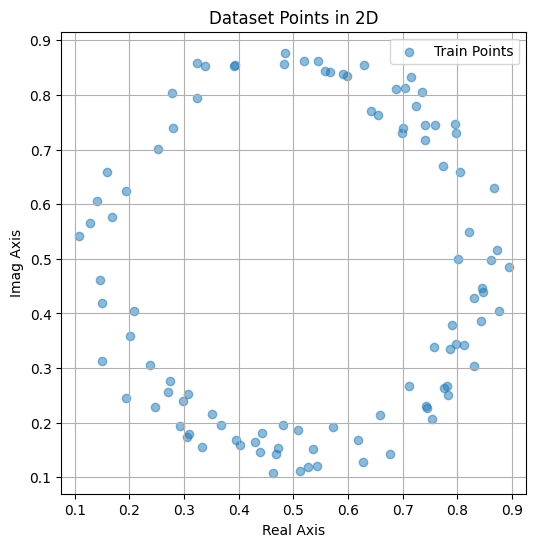

In [4]:
plot_dataset_points(generate_annulus_points_torch(.3, .4, 100, device='cpu'))

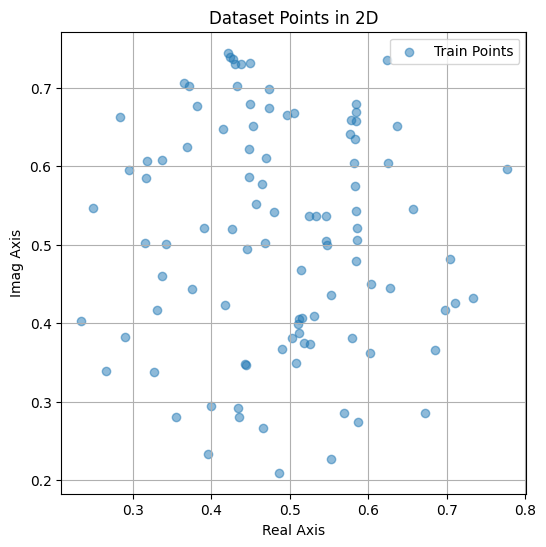

In [5]:
plot_dataset_points(sample_truncated_gaussian(100,  [.5,.5], .2, .3))

In [6]:
def f_symm(f,Delta_phi):
      
        def g(z):
                Z = z[:,0]
                Zb = z[:,1]  
                return (f(z) + f(1.0 - z)).flatten()* torch.pow((Z * Zb) , Delta_phi)
        return g

def crossing_equation(z, phi_func, Delta_phi):
        
        Z = z[:,0]
        Zb = z[:,1]
        term1 = torch.pow((Z * Zb) , -Delta_phi) * phi_func(z).flatten()
        term2 = torch.pow((1 - Z) * (1 - Zb),-Delta_phi) * phi_func(1-z).flatten()
        return term1 - term2

def data_loss(phi4pt_nn,phi4pt_func_true,sigma=0.2, max_radius=0.3,num_samples=100):
    z=sample_truncated_gaussian(num_samples=num_samples, mean=[.5,.5],
                                      sigma=sigma, 
                                      max_radius=max_radius)
    
    true_val=phi4pt_func_true(z)
    pred=phi4pt_nn(z).flatten()
    data_loss=nn.MSELoss()(true_val,pred)
    
    
    return data_loss

def crossing_loss(phi4pt_nn,Delta_phi,take_log=False,r_min=.3,r_max=.4,n_pts=100):
        z=generate_annulus_points_torch(r_min, r_max, n_pts)  
        cr=crossing_equation(z, phi4pt_nn, Delta_phi)
        if(take_log):
                return torch.log(torch.mean(cr**2))
        return torch.mean(cr**2)

        
def total_loss(phi4pt_nn,phi4pt_func_true,Delta_phi,take_log_cr=False,lambda_cr=1.0,lambda_data=1.0,r_min_cr=.3,r_max_cr=.4,n_pts_cr=100,sigma_data=.2,max_radius_data=.4,num_samples_data=100):
        cr_loss=crossing_loss(phi4pt_nn,Delta_phi,take_log_cr,r_min_cr,r_max_cr,n_pts_cr)
        d_loss=data_loss(phi4pt_nn,phi4pt_func_true,sigma_data, max_radius_data,num_samples_data)
        return cr_loss, d_loss,lambda_cr*cr_loss+lambda_data*d_loss


In [7]:
def train_net_symm(model,f,Delta_phi,num_epochs,optimizer,print_interval,r_max=.4,num_samples=100):
    loss_history=[]
    for epoch in range(1, num_epochs + 1):
        optimizer.zero_grad()
        
        
        # Compute loss
        loss = data_loss(f_symm(model,Delta_phi),f, max_radius=r_max,num_samples=num_samples)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Record loss
        loss_history.append(loss.item())
        
        # Print loss at intervals
        if epoch % print_interval == 0 or epoch == 1:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item():.8f}')
    return loss_history


In [8]:
def train_net(model,f,Delta_phi,num_epochs,optimizer,print_interval,lambda_data=1.,lambda_cr=1.,r_min=.3,r_max=.4,n_pts_cr=100,take_log=False):
    loss_history=[]
    for epoch in range(1, num_epochs + 1):
        optimizer.zero_grad()
        
        
        # Compute loss
        loss_cr,loss_data,loss = total_loss(model,f,Delta_phi,take_log_cr=take_log,r_max_cr=r_max,n_pts_cr=n_pts_cr)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Record loss
        loss_history.append(loss.item())
        
        # Print loss at intervals
        if epoch % print_interval == 0 or epoch == 1:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item():.8f}, Loss_crossing: {loss_cr.item():.8f}, Loss_data: {loss_data.item():.8f}')
    return loss_history


checkpoint directory created: ./model
saving model version 0.0
Epoch 1/5000, Loss: 3.84145951
Epoch 500/5000, Loss: 1.55557072
Epoch 1000/5000, Loss: 0.06552729
Epoch 1500/5000, Loss: 0.01070940
Epoch 2000/5000, Loss: 0.01012618
Epoch 2500/5000, Loss: 0.00965056
Epoch 3000/5000, Loss: 0.01125735
Epoch 3500/5000, Loss: 0.00976164
Epoch 4000/5000, Loss: 0.01041274
Epoch 4500/5000, Loss: 0.00987997
Epoch 5000/5000, Loss: 0.00931496


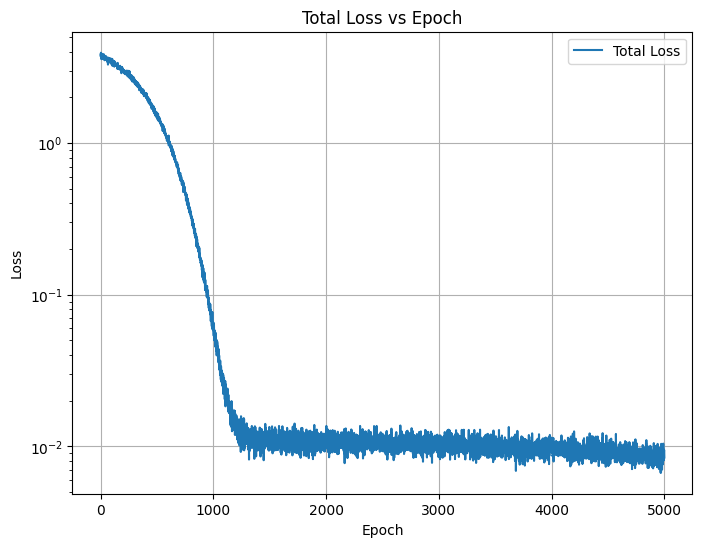

In [9]:
from torch import optim

model = KAN(width=[2,5,5,1], device=device).to(device)

# Define the optimizer
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Parameters
num_epochs = 5000
print_interval = 500


loss_history=train_net_symm(model,f,Delta_phi,num_epochs,optimizer,print_interval,r_max=.3,num_samples=500)

#loss_history =train_net(model,f,Delta_phi,num_epochs,optimizer,print_interval,lambda_cr=1,r_min=0.,r_max=.4,n_pts_cr=1000)

# Plot Loss vs Epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_history, label='Total Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
loss_history=train_net_symm(model,f,Delta_phi,num_epochs,optimizer,print_interval,r_max=.3,num_samples=500)

Epoch 1/5000, Loss: 0.00886951
Epoch 500/5000, Loss: 0.00899658
Epoch 1000/5000, Loss: 0.01031882
Epoch 1500/5000, Loss: 0.01033349
Epoch 2000/5000, Loss: 0.00994871
Epoch 2500/5000, Loss: 0.00857551
Epoch 3000/5000, Loss: 0.00860835
Epoch 3500/5000, Loss: 0.00756293
Epoch 4000/5000, Loss: 0.00713436
Epoch 4500/5000, Loss: 0.00797007
Epoch 5000/5000, Loss: 0.00597444


In [ ]:
loss_history =train_net(model,f,Delta_phi,5000,optimizer,print_interval,take_log=True,lambda_cr=10,r_min=0.,r_max=.4,n_pts_cr=500)

Epoch 1/5000, Loss: -7.80857801, Loss_crossing: -8.12491035, Loss_data: 0.31633252
Epoch 500/5000, Loss: -7.97811794, Loss_crossing: -8.25837803, Loss_data: 0.28026012
Epoch 1000/5000, Loss: -8.07514191, Loss_crossing: -8.35012722, Loss_data: 0.27498570
Epoch 1500/5000, Loss: -8.12508202, Loss_crossing: -8.40223408, Loss_data: 0.27715239
Epoch 2000/5000, Loss: -8.17649651, Loss_crossing: -8.52047348, Loss_data: 0.34397683
Epoch 2500/5000, Loss: -8.12090683, Loss_crossing: -8.45052242, Loss_data: 0.32961524
Epoch 3000/5000, Loss: -8.02599049, Loss_crossing: -8.40296364, Loss_data: 0.37697285
Epoch 3500/5000, Loss: -7.95793867, Loss_crossing: -8.33782005, Loss_data: 0.37988156
Epoch 4000/5000, Loss: -8.26294518, Loss_crossing: -8.61783218, Loss_data: 0.35488740
Epoch 4500/5000, Loss: -8.20444202, Loss_crossing: -8.60707664, Loss_data: 0.40263447
Epoch 5000/5000, Loss: -8.13597107, Loss_crossing: -8.57014370, Loss_data: 0.43417281


In [ ]:
loss_history =train_net(model,f,Delta_phi,num_epochs,optimizer,print_interval,lambda_cr=2,r_max=.4)


Epoch 1/1500, Loss: 0.00188974, Loss_crossing: 0.00109200, Loss_data: 0.00079774
Epoch 500/1500, Loss: 0.00120507, Loss_crossing: 0.00055137, Loss_data: 0.00065370
Epoch 1000/1500, Loss: 0.00122216, Loss_crossing: 0.00045734, Loss_data: 0.00076482
Epoch 1500/1500, Loss: 0.00116425, Loss_crossing: 0.00040117, Loss_data: 0.00076308


In [45]:
loss_history =train_net(model,f,Delta_phi,num_epochs,optimizer,print_interval,lambda_cr=2,r_max=.4)

Epoch 1/1500, Loss: 0.00095330, Loss_crossing: 0.00048178, Loss_data: 0.00047153
Epoch 500/1500, Loss: 0.00090612, Loss_crossing: 0.00043634, Loss_data: 0.00046978
Epoch 1000/1500, Loss: 0.00084380, Loss_crossing: 0.00042950, Loss_data: 0.00041430
Epoch 1500/1500, Loss: 0.00065792, Loss_crossing: 0.00024869, Loss_data: 0.00040923


In [46]:
loss_history =train_net(model,f,Delta_phi,num_epochs,optimizer,print_interval,lambda_cr=.1,r_max=.4)

Epoch 1/1500, Loss: 0.00068154, Loss_crossing: 0.00033090, Loss_data: 0.00035064


KeyboardInterrupt: 

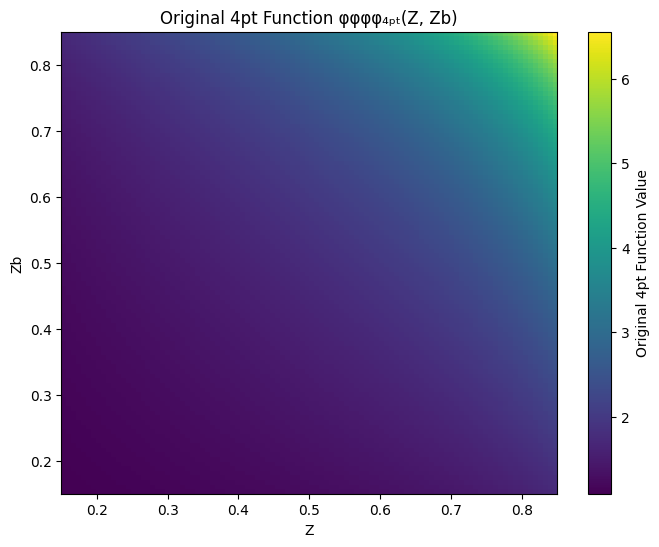

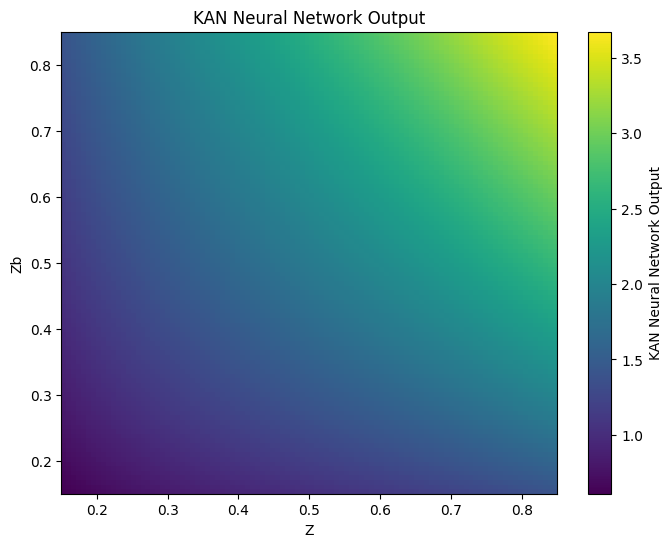

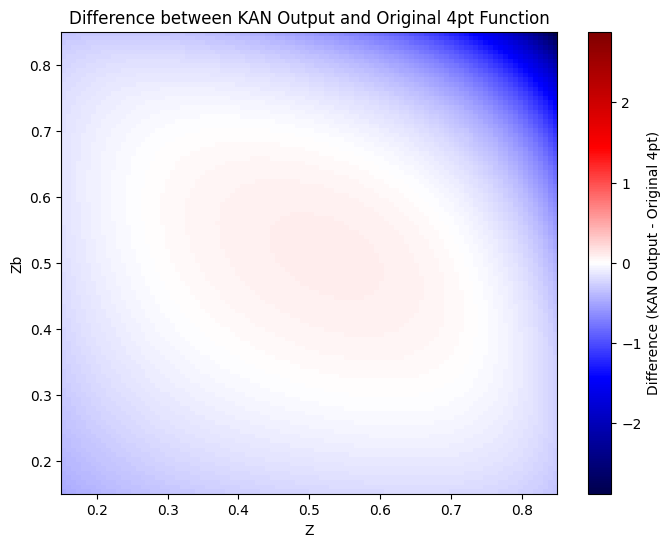

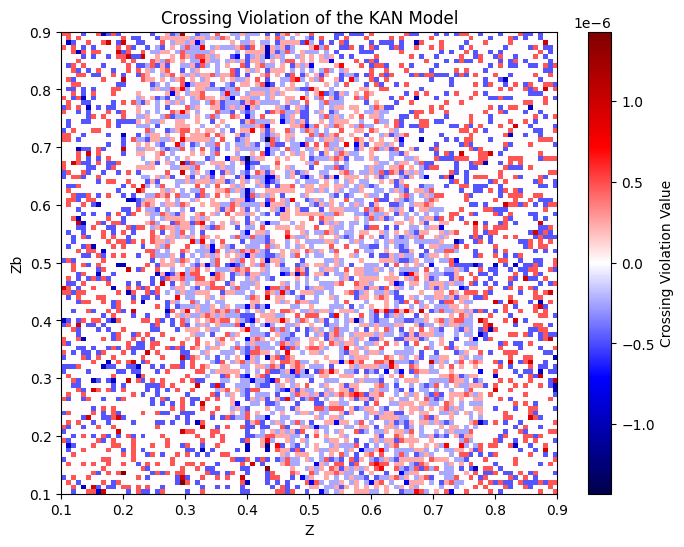

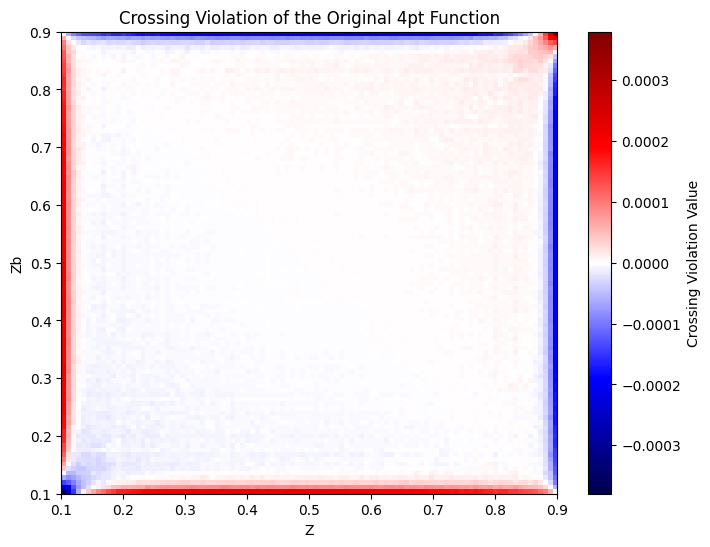

In [14]:
plot_results(f_symm(model,Delta_phi), f, device)
plot_crossing_violation(f_symm(model,Delta_phi), f, Delta_phi, device,zmin=.1,zmax=.9)


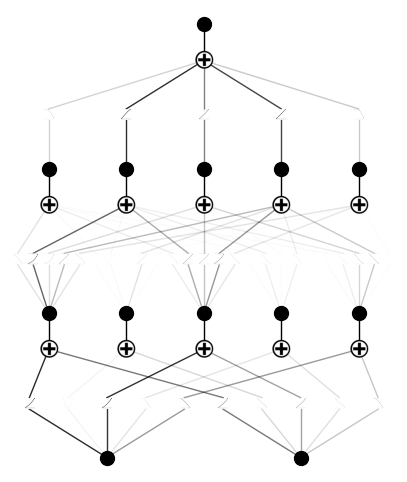

In [11]:
model.plot()

TODO EXTRACT analytic

In [12]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)
model.symbolic_formula()

fixing (0,0,0) with sin, r2=1.0000001192092896, c=2
fixing (0,0,1) with x, r2=0.004892499651759863, c=1
fixing (0,0,2) with sin, r2=0.9999983906745911, c=2
fixing (0,0,3) with sin, r2=0.9999974370002747, c=2
fixing (0,0,4) with sin, r2=1.0000001192092896, c=2
fixing (0,1,0) with sqrt, r2=0.9999690055847168, c=2
fixing (0,1,1) with x, r2=0.9987841844558716, c=1
fixing (0,1,2) with x, r2=0.9938923120498657, c=1
fixing (0,1,3) with x, r2=0.9838576316833496, c=1
fixing (0,1,4) with sin, r2=0.999999463558197, c=2
fixing (1,0,0) with sin, r2=1.0000001192092896, c=2
fixing (1,0,1) with exp, r2=0.9999832510948181, c=2
fixing (1,0,2) with exp, r2=0.9996793270111084, c=2
fixing (1,0,3) with x, r2=0.9994899034500122, c=1
fixing (1,0,4) with log, r2=0.9996679425239563, c=2
fixing (1,1,0) with exp, r2=1.0000003576278687, c=2
fixing (1,1,1) with sin, r2=0.9999938607215881, c=2
fixing (1,1,2) with x^2, r2=0.9981908798217773, c=2
fixing (1,1,3) with x, r2=0.9998786449432373, c=1
fixing (1,1,4) with x^

([-0.000766984794551188*x_1 - 0.0381114090571788*x_2 - 0.0598211024600926*sqrt(1 - 0.966167401585826*x_2) + 0.775945030805654*exp(0.00533134020255575*(0.0201248081224306*x_1 + x_2 - 0.488391733701902)**2 - 0.644860193165169*sqrt(-0.224390284962557*x_2 + 0.48763609142196*sin(1.67591989040375*x_1 - 4.57000017166138) + 1) + 0.768007337054921*exp(-1.64678641907762*sqrt(1 - 0.966167401585826*x_2) + 2.93175022465536*sin(1.13567984104156*x_1 - 7.60552024841309)) + 0.162431875080475*sin(0.796820708046596*sin(1.60495984554291*x_1 + 8.19695949554443) + 0.483250446642103*sin(1.89999985694885*x_2 + 1.37727987766266) - 9.29853573554016))/(-0.601177946797982*x_2 + 0.203195952988529*sin(3.25255990028381*x_1 + 7.38104009628296) + 1)**0.0116161273451336 - 0.0357827041405582*exp(-0.595963915409875*x_2 + 0.201433629399546*sin(3.25255990028381*x_1 + 7.38104009628296)) + 0.173325210575717*exp(0.327054630659247*x_2 - 0.710742186555628*sin(1.67591989040375*x_1 - 4.57000017166138)) + 0.106498650064615*sin(1.1

In [15]:
model.symbolic_formula()

([0.00131877819267806*x_1 + 0.00456883289906268*x_2 - 0.0818873679113113*sqrt(1 - 0.96522977151493*x_2) - 1.57756451714591*exp(-0.0253523633450085*(-0.0108962096858832*x_1 - 0.0377493058077141*x_2 - 1)**2 - 0.658027794801085*sqrt(-0.197754801379266*x_2 + 0.48400555411472*sin(1.67355036735535*x_1 - 4.5733847618103) + 1) - 507.901706244937*exp(-1.6767824976189*sqrt(1 - 0.96522977151493*x_2) + 2.94204652371177*sin(1.1328330039978*x_1 - 7.60836410522461)) + 0.167226147276857*sin(0.807103856673592*sin(1.60224735736847*x_1 + 8.19420337677002) + 0.491862255751059*sin(1.89764130115509*x_2 + 1.37441992759705) - 9.28041528083932))/(-0.625011263953195*x_2 + 0.247475385144285*sin(3.2562472820282*x_1 + 7.38834571838379) + 1)**0.0167025520249746 + 0.38816250010905*exp(-0.642816247740501*x_2 + 0.254525330440281*sin(3.2562472820282*x_1 + 7.38834571838379)) + 0.227792732637315*exp(0.297187129282816*x_2 - 0.727366517429971*sin(1.67355036735535*x_1 - 4.5733847618103)) + 0.14367781536454*sin(1.13283300399